# LSA and NMF Topic Modeling

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from collections import Counter

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import random

from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import text

import gensim
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn

In [95]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/kari/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Cleaning Data

In [2]:
convosdf = pd.read_csv("convo_texts.csv")

In [3]:
regex ="\B@\w+"
convosdf.text = convosdf.text.str.replace(regex, '')

In [4]:
regex ="http\S+"
convosdf.text = convosdf.text.str.replace(regex, '')

In [5]:
convosdf.head()

,tweet_ids,text
0,1 2 3 4 5 6 7 8 9 10,I understand. I would like to assist you. We...
1,11 12 13 14 15 16 17 18,This is saddening to hear. Please shoot us a...
2,19 20,Please send me a private message so that I c...
3,21 22 23 24 25 28 26 29 27,What information is incorrect? ^JK Would yo...
4,30 31,"Hello, My apologies for any frustrations or ..."


In [7]:
# removing everything except alphabets`
convosdf['clean_text'] = convosdf['text'].str.replace("[^a-zA-Z#]", " ")

# removing short words
convosdf['clean_text'] = convosdf['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# make all text lowercase
convosdf['clean_text'] = convosdf['clean_text'].apply(lambda x: x.lower())

In [8]:
convos = convosdf.clean_text.tolist()

In [9]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
split_convos = list(sent_to_words(convos))

In [10]:
all_words = [word for convo in split_convos for word in convo]

for word in all_words:
    word = word.lower()

In [13]:
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

In [14]:
domain_stopwords = ['thank', 'dm', 'issue', 'app', 'order', 'phone', 'number', 'account', 'service', 'time',
                    'link', 'apology', 'direct_message', 'thanks', 'help', 'email', 'sorry', 'team', 'issues',
                    'just', 'like', 'hello', 'assist', 'want', 'know', 'idea', 'details', 'check', 'look', 
                    'make', 'need', 'soon', 'check', 'send', 'private', 'message', 'kindly', 'rgds', 'still', 
                    'customer', 'regard', 'please', 'would']

english_stopwords = stopwords.words('english')

clean_convos = []

for convo in split_convos:
    no_stop = [word for word in convo if word not in english_stopwords]
    
    no_domain = [word for word in no_stop if word not in domain_stopwords]

    clean_words = [get_lemma(word) for word in no_domain]
    
    clean_convos.append(clean_words)

### CountVectorizer

In [16]:
vectorizer = CountVectorizer(min_df=0.005, max_df=0.995, tokenizer=lambda doc: doc, lowercase=False)

doc_word = vectorizer.fit_transform(clean_convos)
doc_word.toarray().shape

(798197, 725)

In [17]:
len(vectorizer.get_feature_names())

725

### LSA

In [18]:
lsa = TruncatedSVD(5)
doc_topic = lsa.fit_transform(doc_word)
lsa.explained_variance_ratio_

array([0.05000258, 0.03373982, 0.02046725, 0.01703622, 0.01512279])

In [19]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2", "component_3", "component_4", "component_5"], columns = vectorizer.get_feature_names())
topic_word

,able,absolutely,accept,access,account,acct,action,actually,add,additional,...,worse,worst,worth,write,wrong,xbox,yeah,year,years,yesterday
component_1,0.095,0.013,0.013,0.033,0.009,0.010,0.013,0.026,0.015,0.016,...,0.008,0.024,0.007,0.013,0.028,0.041,0.021,0.029,0.033,0.025
component_2,-0.015,-0.002,-0.001,-0.003,-0.001,-0.001,0.001,-0.005,-0.002,-0.002,...,-0.002,-0.002,-0.001,0.002,-0.002,-0.017,-0.006,-0.005,-0.007,-0.003
component_3,0.016,-0.005,-0.006,-0.006,-0.004,-0.006,-0.004,-0.000,-0.006,-0.010,...,0.001,0.001,-0.002,-0.011,-0.016,0.132,0.019,-0.013,-0.012,-0.004
component_4,0.000,-0.002,0.001,-0.024,-0.006,-0.009,-0.008,0.002,-0.001,-0.006,...,-0.000,-0.007,-0.000,-0.005,-0.007,0.018,0.004,0.010,-0.006,-0.003
component_5,-0.021,0.013,-0.005,-0.016,0.006,0.009,-0.014,0.009,0.018,0.012,...,0.006,-0.001,0.004,-0.012,-0.012,-0.025,0.007,0.032,0.060,-0.025


In [20]:
cols = topic_word.columns.tolist()

In [21]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [22]:
display_topics(lsa, vectorizer.get_feature_names(), 10)


Topic  0
back, update, take, call, game, address, flight, try, hear, work

Topic  1
request, response, kind, regard, amazon, reply, booking, refund, receive, concern

Topic  2
game, error, server, play, update, code, xbox, getting, problem, working

Topic  3
flight, delay, booking, train, ticket, game, change, book, travel, cancel

Topic  4
iphone, love, mobile, line, plan, happy, great, take, deal, store


In [23]:
Vt = pd.DataFrame(doc_topic.round(3),
             index = convos,
             columns = ["component_1","component_2", "component_3", "component_4", "component_5"])

In [24]:
num_components = np.arange(1,20).tolist()
var = []

for num in num_components:
    
    lsa = TruncatedSVD(num)
    doc_topic = lsa.fit_transform(doc_word)
    var.append(lsa.explained_variance_ratio_)

In [25]:
var = [v.tolist() for v in var]

var_steps = []

idx = 0
for v in var:
    var_steps.append(v[idx])
    idx += 1

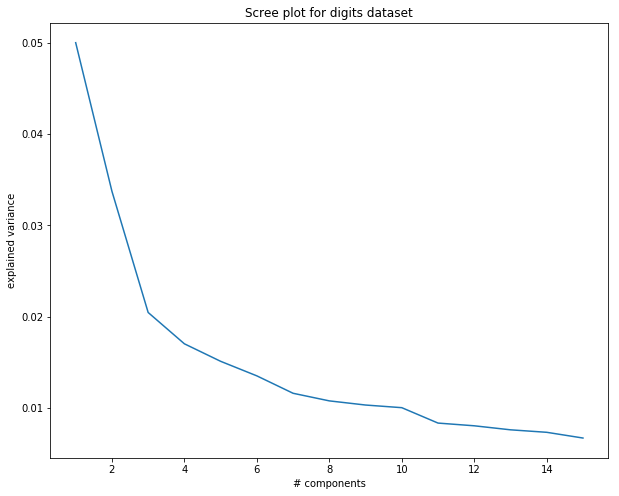

In [26]:
plt.figure(figsize=(10,8))
plt.plot(num_components[:15], var_steps[:15])
plt.xlabel('# components')
plt.ylabel('explained variance');
plt.title('Scree plot for digits dataset');

### NMF

For my project, I selected the following topics derived from NMF becuase they were the most clear and separate.

In [27]:
nmf_model = NMF(5)
doc_topic = nmf_model.fit_transform(doc_word)

In [28]:
topic_word = pd.DataFrame(nmf_model.components_.round(3), index = ["component_1","component_2", "component_3",
                                                                   "component_4","component_5"], 
                          columns = vectorizer.get_feature_names())
topic_word

,able,absolutely,accept,access,account,acct,action,actually,add,additional,...,worse,worst,worth,write,wrong,xbox,yeah,year,years,yesterday
component_1,2.305,0.630,0.332,0.798,0.414,0.583,0.176,0.927,0.727,0.729,...,0.349,0.722,0.302,0.180,0.712,0.000,0.633,1.386,1.969,0.386
component_2,0.000,0.000,0.008,0.000,0.000,0.009,0.051,0.000,0.009,0.000,...,0.000,0.027,0.000,0.053,0.012,0.000,0.000,0.008,0.000,0.000
component_3,1.766,0.029,0.079,0.330,0.019,0.000,0.126,0.330,0.065,0.000,...,0.114,0.328,0.054,0.000,0.121,3.498,0.671,0.052,0.000,0.372
component_4,0.866,0.095,0.197,0.000,0.000,0.000,0.016,0.237,0.131,0.091,...,0.057,0.077,0.060,0.134,0.285,0.000,0.094,0.447,0.067,0.247
component_5,1.538,0.067,0.255,0.983,0.085,0.024,0.502,0.198,0.050,0.181,...,0.016,0.410,0.052,0.534,0.735,0.000,0.003,0.000,0.000,0.779


In [29]:
display_topics(nmf_model, vectorizer.get_feature_names(), 10)


Topic  0
take, address, back, store, love, iphone, call, happy, mobile, try

Topic  1
request, response, kind, regard, reply, concern, booking, call, resolve, care

Topic  2
game, error, update, server, play, code, getting, problem, xbox, working

Topic  3
flight, delay, booking, train, ticket, change, book, cancel, refund, wait

Topic  4
delivery, amazon, receive, provide, contact, deliver, call, refund, back, update


In [30]:
topic_vectors_df = pd.DataFrame(doc_topic.round(5), index = convos,
             columns = ["component_1","component_2", "component_3", "component_4", "component_5"])

In [31]:
ids = convosdf.tweet_ids.tolist()
topic_vectors_df['tweet_ids'] = ids

In [32]:
topic_vectors_df.head(3)

,component_1,component_2,component_3,component_4,component_5,tweet_ids
understand would like assist would need into private secured link further assist propose that have sent several private messages responding usual please send private message that further assist just click message your profile please send private message that gain further details about your account only response tweet apparently worst customer service would love chance review account provide assistance hello never like customers feel like they valued,0.01947,0.02068,0.00000,0.00000,0.01811,1 2 3 4 5 6 7 8 9 10
this saddening hear please shoot that look into this gonna magically change your connectivity whole family would really like work with have this resolved kindly send here resolutionsup name shantel resolution supervisor here with sprint your issues brought attention resolutionsup understand your concerns like please send direct message that further assist since signed with since there definitely like work with this long have been experiencing this issue about your great connection bars still load something,0.03878,0.00000,0.01416,0.00651,0.00000,11 12 13 14 15 16 17 18
please send private message that send link access your account whenever contact customer support they tell have shortcode enabled account have never years tried,0.01036,0.00000,0.00000,0.00000,0.01648,19 20


In [33]:
topic_vectors_df.to_pickle("./topic_vectors.pkl")

### TF-IDF

In [35]:
tfidf = TfidfVectorizer(min_df=0.005, max_df=0.995, tokenizer=lambda doc: doc, lowercase=False)
doc_word_tf = tfidf.fit_transform(clean_convos)
doc_word_tf.shape

(798197, 725)

In [36]:
nmf_model_tf = NMF(5)
doc_topic_tf = nmf_model_tf.fit_transform(doc_word_tf)

In [37]:
topic_word = pd.DataFrame(nmf_model_tf.components_.round(3), index = ["component_1","component_2", "component_3",
                                                                   "component_4","component_5"], 
                          columns = tfidf.get_feature_names())
topic_word

,able,absolutely,accept,access,account,acct,action,actually,add,additional,...,worse,worst,worth,write,wrong,xbox,yeah,year,years,yesterday
component_1,1.113,0.187,0.208,0.486,0.141,0.107,0.176,0.293,0.238,0.271,...,0.104,0.408,0.117,0.204,0.557,0.351,0.163,0.340,0.260,0.422
component_2,0.000,0.000,0.000,0.041,0.002,0.000,0.013,0.000,0.000,0.000,...,0.000,0.000,0.002,0.005,0.019,0.000,0.000,0.000,0.000,0.011
component_3,0.148,0.020,0.000,0.055,0.008,0.000,0.005,0.052,0.039,0.030,...,0.060,0.029,0.007,0.017,0.022,0.171,0.054,0.043,0.050,0.033
component_4,0.214,0.064,0.073,0.000,0.000,0.000,0.000,0.059,0.041,0.011,...,0.025,0.052,0.037,0.000,0.000,0.000,0.039,0.131,0.051,0.079
component_5,0.098,0.046,0.023,0.073,0.066,0.358,0.009,0.036,0.009,0.094,...,0.036,0.130,0.013,0.002,0.114,0.000,0.012,0.018,0.040,0.035


In [38]:
display_topics(nmf_model_tf, tfidf.get_feature_names(), 10)


Topic  0
call, store, contact, back, hear, delivery, receive, provide, support, try

Topic  1
amazon, prime, hola, para, delivery, deliver, package, mail, order, twitter

Topic  2
update, iphone, work, software, fix, version, around, future, device, using

Topic  3
flight, delay, great, train, hope, confirmation, enjoy, crew, today, love

Topic  4
address, full, name, internet, happy, take, follow, could, outage, apologize


### Topic Wordclouds

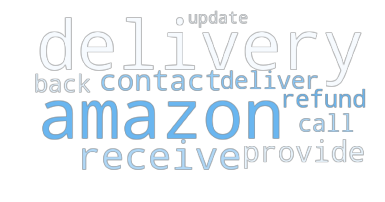

In [40]:
text = "delivery amazon receive provide contact deliver call refund back update"

wordcloud = WordCloud(mode='RGBA', background_color=None).generate(text)

def blue_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(206, 82%%, %d%%)" % random.randint(60, 100)

plt.imshow(wordcloud.recolor(color_func=blue_color_func, random_state=3), interpolation='bilinear')
plt.axis("off")
plt.show()
# plt.savefig("topic1.svg");